In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import pandas as pd

# Define the URL for the API
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

# Define the SQL query to retrieve the required data
query = """
SELECT 
    pl_name, 
    hostname, 
    default_flag,
    pl_orbsmax, 
    pl_orbsmaxerr1, 
    pl_orbsmaxerr2, 
    pl_rade,
    pl_radeerr1,
    pl_radeerr2,
    pl_bmasse, 
    pl_bmasseerr1, 
    pl_bmasseerr2, 
    sy_pnum, 
    pl_orbeccen, 
    pl_orbeccenerr1, 
    pl_orbeccenerr2, 
    pl_orbincl, 
    pl_orbinclerr1, 
    pl_orbinclerr2
FROM ps
WHERE 
    sy_pnum > 1
"""
# we used to have default_flag = 1 AND sy_snum = 1

# Define the parameters for the request
params = {
    "query": query,
    "format": "json",
}

# Make the request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df_query = pd.DataFrame(data)
    
    # Display the DataFrame
    # print(df)
else:
    print(f"Error: {response.status_code}")

In [16]:
df = df_query.copy()

In [17]:
drop_indices = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # we check the names of the planets in the system
    # if they use a different naming convention, we discard the system
    names = df_host["pl_name"]
    # check if the first three characters are the same
    if len(set([name[:3] for name in names])) > 1:
        # discard the system
        print(f"Discarding {hostname}")
        drop_indices.extend(df_host.index)

df.drop(df.index[drop_indices], inplace=True)
# Later we can do something more sophisticated to match the names

Discarding GJ 143
Discarding HD 39091
Discarding KOI-12
Discarding HIP 8541
Discarding HD 22946
Discarding KOI-351
Discarding KOI-142
Discarding 14 Her
Discarding Kepler-324
Discarding K2-168
Discarding KOI-7892
Discarding GJ 411
Discarding HD 80653
Discarding KIC 5437945
Discarding 2MASS J19383260+4603591
Discarding K2-166
Discarding K2-282
Discarding K2-16
Discarding KIC 9663113
Discarding K2-50
Discarding Kepler-968


In [19]:
keep_indices = []

for planet in df["pl_name"].unique():
    df_planet = df[df["pl_name"] == planet]
    # we average the parameters for each planet in the system
    # so there will be for instance 2 rows correpsonding to the same planet
    # and we will have the average of the parameters
    default_index = df_planet[df_planet["default_flag"] == 1].index
    # print(f"Processing {planet}, default indices: {default_index}")
    for col in df_planet.columns[3:]:
        # take the average of the values (ignoring NaNs)
        avg = np.nanmedian(df_planet[col].values)
        # overwrite the values in the original df where default_flag = 1
        # print(f"Overwriting {col} for {planet} with {avg}")
        df.loc[default_index, col] = avg
    keep_indices.extend(default_index)

df.drop(df.index[~df.index.isin(keep_indices)], inplace=True)

In [22]:
df[df["hostname"] == "WASP-47"][["pl_name", "pl_orbsmax"]].values

array([['WASP-47 b', 0.0515],
       ['WASP-47 c', 1.393],
       ['WASP-47 d', 0.0865],
       ['WASP-47 e', 0.017015]], dtype=object)

In [21]:
np.nanmean([np.nan, np.nan])

nan

if the semimaj axis is missing, run a second search and average the values and uncertainties found

For later...

In [3]:
# FLAGS:
# flag = 0 (default): all values present from the retrieved data
# flag = 01: we assume eccentricity of the planet from the e-N anti-correlation
# flag = 02: we assume mass of the planet using mass-radius relation (spright)
# flag = 03: we assume inclination of the missing planets are coplanar wrt the most massive planet in the system
# flag = 012: mix of 1 and 2
# flag = 013: mix of 1 and 3
# flag = 023: mix of 2 and 3
# flag = 0123: mix of 1, 2 and 3

In [4]:
df["flag"] = "0"

Fill in the missing values in eccentricity

In [5]:
# select rows where the pl_orbeccen is nan
eccnan_index = df[df['pl_orbeccen'].isnull()].index
df.loc[eccnan_index, 'pl_orbeccen'] = 0.63 * df.loc[eccnan_index, 'sy_pnum']**(-1.02)
df.loc[eccnan_index, 'pl_orbeccenerr1'] = 0.0
df.loc[eccnan_index, 'pl_orbeccenerr2'] = 0.0

df.loc[eccnan_index, 'flag'] += "1"

In [6]:
from spright import RMRelation
rmr = RMRelation()

plmassnan_index = df[df['pl_bmasse'].isnull() & (df['pl_rade'] > 0.5) & (df['pl_rade'] < 6.0) & (~df['pl_radeerr1'].isnull() & ~df['pl_radeerr2'].isnull())].index

df.loc[plmassnan_index, 'flag'] += "2"

/Users/andrea/git/ExoNAMD/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
for n, idx in enumerate(plmassnan_index):
    # if n % 100 == 0:
    #     print(idx)
    mds = rmr.predict_mass(
        radius=(
            df.loc[idx, 'pl_rade'], 
            0.5 * (df.loc[idx, 'pl_radeerr1'] - df.loc[idx, 'pl_radeerr2']))
        )
    q16, q50, q84 = np.percentile(mds.samples, [16, 50, 84])
    df.loc[idx, 'pl_bmasse'] = q50
    df.loc[idx, 'pl_bmasseerr1'] = q84 - q50
    df.loc[idx, 'pl_bmasseerr2'] = q16 - q50

In [12]:
# remove systems where at least one planet has no mass
for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    if df_host["pl_bmasse"].isnull().any():
        print(f"Removing {hostname}")
        df = df.drop(df_host.index)

Removing GJ 667 C
Removing Kepler-397
Removing WASP-132
Removing HIP 41378
Removing V1298 Tau
Removing TOI-1634
Removing Kepler-450
Removing Kepler-37
Removing KOI-351
Removing Kepler-444
Removing Kepler-1130
Removing Kepler-1600
Removing Kepler-783
Removing Kepler-975
Removing Kepler-1468
Removing Kepler-1321
Removing Kepler-305
Removing Kepler-352
Removing Kepler-511
Removing Kepler-394
Removing Kepler-54
Removing Kepler-1085
Removing Kepler-647
Removing Kepler-616
Removing Kepler-196
Removing Kepler-49
Removing Kepler-1801
Removing Kepler-1814
Removing Kepler-281
Removing Kepler-381
Removing Kepler-1266
Removing Kepler-1869
Removing Kepler-297
Removing Kepler-27
Removing Kepler-1921
Removing Kepler-1894
Removing Kepler-1669
Removing Kepler-416
Removing Kepler-487
Removing Kepler-799
Removing Kepler-1067
Removing Kepler-529
Removing Kepler-1488
Removing Kepler-1311
Removing Kepler-633
Removing Kepler-501
Removing Kepler-1090
Removing Kepler-1315
Removing Kepler-1001
Removing Kepler-1

In [15]:
# get rid of columns with rade
df = df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"])

KeyError: "['pl_rade', 'pl_radeerr1', 'pl_radeerr2'] not found in axis"

In [19]:
# input missing inclinations
for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]

    inclnan_index = df_host[df_host['pl_orbincl'].isnull()].index

    sytem_multiplicity = df_host["sy_pnum"].max()
    # maxmass_pl = df_host["pl_bmasse"].idxmax()  # this is deprecated by pandas
    maxmass_pl = df_host["pl_bmasse"].max()
    maxmass_pl = df_host[df_host["pl_bmasse"] == maxmass_pl].index[0]

    # if all the inclinations are nan, set them to 90
    if len(inclnan_index) == sytem_multiplicity:
        df.loc[inclnan_index, 'pl_orbincl'] = 90.0
        df.loc[inclnan_index, 'pl_orbinclerr1'] = 0.0
        df.loc[inclnan_index, 'pl_orbinclerr2'] = 0.0
        df.loc[inclnan_index, 'flag'] += "3"

    # if the most massive planet has inclination nan, set all the inclinations to 90
    ### we can consider changing this to the next most massive planet later on ###
    elif maxmass_pl in inclnan_index:
        df.loc[inclnan_index, 'pl_orbincl'] = 90.0
        df.loc[inclnan_index, 'pl_orbinclerr1'] = 0.0
        df.loc[inclnan_index, 'pl_orbinclerr2'] = 0.0
        df.loc[inclnan_index, 'flag'] += "3"

    # if any planet other than the most massive planet has inclination nan, set them to the inclination of the most massive planet
    else:
        for idx in inclnan_index:
            df.loc[idx, 'pl_orbincl'] = df.loc[maxmass_pl, 'pl_orbincl']
            df.loc[idx, 'pl_orbinclerr1'] = df.loc[maxmass_pl, 'pl_orbinclerr1']
            df.loc[idx, 'pl_orbinclerr2'] = df.loc[maxmass_pl, 'pl_orbinclerr2']
            df.loc[idx, 'flag'] += "3"
    

In [20]:
df['flag']

0         03
1        013
2          0
3          0
4          0
        ... 
2389       0
2390    0123
2391      02
2392      02
2393      02
Name: flag, Length: 2158, dtype: object

In [23]:
df[df["hostname"] == "WASP-47"]

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag
2,WASP-47 b,WASP-47,NaN,NaN,NaN,374.0,17.0,-16.0,4,0.0006,0.0005,-0.0002,89.00,0.17,-0.17,0
3,WASP-47 c,WASP-47,NaN,NaN,NaN,447.0,18.0,-22.0,4,0.2640,0.0070,-0.0120,90.00,NaN,NaN,0
4,WASP-47 d,WASP-47,NaN,NaN,NaN,15.5,0.7,-0.9,4,0.0010,0.0008,-0.0007,89.23,0.10,-0.10,0
5,WASP-47 e,WASP-47,NaN,NaN,NaN,9.0,0.6,-0.4,4,0.0000,NaN,NaN,86.73,1.76,-1.76,0


In [ ]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # if df_host contains NaN values, save hostname to a list
    if df_host.isnull().values.any():
        # print(df_host)
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

In [ ]:
df_clean

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2
0,BD-08 2823 c,BD-08 2823,0.68000,0.02000,-0.02000,104.000000,10.000000,-10.000000,2,0.190000,0.09,-0.090,90.000,0.000,0.00
6,HD 23472 d,HD 23472,0.04298,0.00063,-0.00065,0.550000,0.210000,-0.200000,5,0.070000,0.05,-0.047,87.950,1.200,-0.87
9,TOI-2096 c,TOI-2096,0.04000,0.00200,-0.00200,4.627209,3.392068,-1.128546,2,0.100000,0.17,-0.060,89.560,0.260,-0.23
41,HD 207832 c,HD 207832,2.11200,0.08700,-0.04500,232.015900,57.209400,-15.891500,2,0.270000,0.22,-0.100,90.000,0.000,0.00
42,K2-133 e,K2-133,0.13460,0.00110,-0.00110,4.331134,2.432472,-1.506740,4,0.153193,0.00,0.000,89.164,0.012,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,K2-239 d,K2-239,0.06850,0.00120,-0.00120,1.240452,0.476706,-0.362085,3,0.205436,0.00,0.000,89.430,0.380,-0.45
2359,EPIC 249893012 d,EPIC 249893012,0.22000,0.02000,-0.04000,10.180000,2.460000,-2.420000,3,0.150000,0.21,-0.110,89.470,0.360,-0.50
2365,K2-240 b,K2-240,0.05130,0.00090,-0.00090,5.112836,2.258318,-1.320829,2,0.310663,0.00,0.000,89.260,0.510,-0.64
2387,K2-188 c,K2-188,0.07850,0.00080,-0.00080,8.932440,2.394841,-2.029337,2,0.310663,0.00,0.000,90.000,0.000,0.00


In [ ]:
df_clean["hostname"].unique().size

274

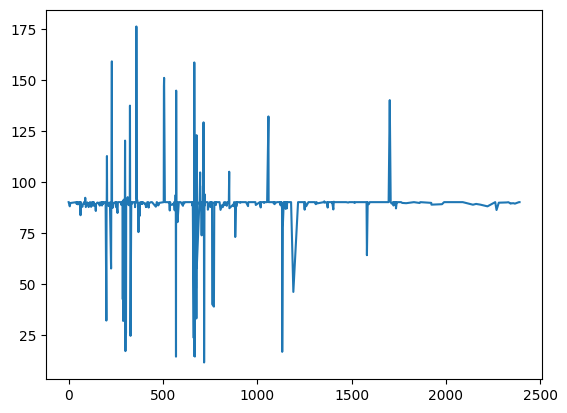

In [ ]:
plt.plot(df_clean["pl_orbincl"])

In [ ]:
# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [ ]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)

In [ ]:
df_clean

,pl_name,hostname,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_relincl,pl_relinclerr1,pl_relinclerr2
715,HD 145675 c,14 Her,11.924000,1.296000,-1.153000,1597.08775,277.46420,-339.12291,2,0.3930,0.0450,-0.0480,129.097,6.255,-29.051,15.555,8.862893,29.231228
570,14 Her b,14 Her,2.774000,0.109000,-0.120000,2559.47216,518.69596,-280.64248,2,0.3730,0.0080,-0.0060,144.652,6.279,-3.241,0.000,8.879847,4.583466
1612,24 Sex b,24 Sex,1.333000,0.004000,-0.009000,632.46000,82.63000,-120.77000,2,0.0900,0.1400,-0.0600,90.000,0.000,0.000,0.000,0.000000,0.000000
1605,24 Sex c,24 Sex,2.080000,0.050000,-0.020000,273.32000,111.24000,-69.92000,2,0.2900,0.1600,-0.0900,90.000,0.000,0.000,0.000,0.000000,0.000000
1104,47 UMa b,47 UMa,2.100000,0.020000,-0.020000,804.08000,22.25000,-19.07000,3,0.0320,0.0140,-0.0140,90.000,0.000,0.000,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,tau Cet e,tau Cet,0.538000,0.060000,-0.060000,3.93000,0.83000,-0.64000,4,0.1800,0.1800,-0.1400,90.000,0.000,0.000,0.000,0.000000,0.000000
1639,tau Cet f,tau Cet,1.334000,0.017000,-0.044000,3.93000,1.05000,-1.37000,4,0.1600,0.0700,-0.1600,90.000,0.000,0.000,0.000,0.000000,0.000000
1172,ups And b,ups And,0.059222,0.000000,-0.000000,218.53100,1.39839,-1.39839,3,0.0215,0.0007,-0.0007,90.000,0.000,0.000,0.000,0.000000,0.000000
1171,ups And d,ups And,2.513290,0.000750,-0.000750,1313.22000,9.21668,-9.21668,3,0.2987,0.0072,-0.0072,90.000,0.000,0.000,0.000,0.000000,0.000000


In [ ]:
def amd(m: np.array, e: np.array, i: np.array, a: np.array) -> np.array:
    return m * np.sqrt(a) * (1 - np.sqrt(1 - e**2) * np.cos(np.deg2rad(i)))

def namd(amd: np.array, m: np.array, a: np.array) -> float:
    return np.sum(amd) / np.sum(m * np.sqrt(a))

In [ ]:
for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

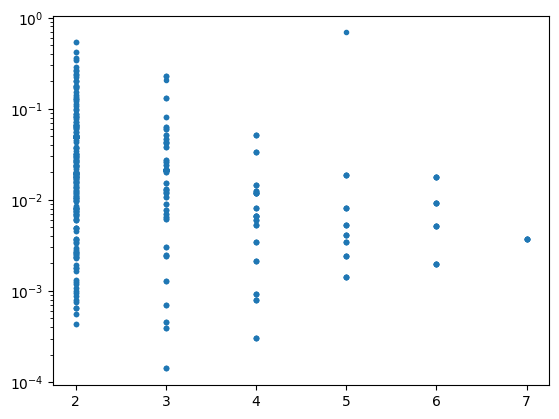

In [ ]:
plt.plot(df_clean["sy_pnum"], df_clean["namd"], '.')
plt.yscale("log")

In [ ]:
df_clean.hostname.unique()

array(['14 Her', '24 Sex', '47 UMa', '55 Cnc', '61 Vir', '75 Cet',
       'BD-08 2823', 'BD-11 4672', 'BD-210397', 'CoRoT-20',
       'EPIC 212737443', 'EPIC 249893012', 'G 264-012', 'GJ 1002',
       'GJ 1148', 'GJ 15 A', 'GJ 163', 'GJ 180', 'GJ 2030', 'GJ 229',
       'GJ 273', 'GJ 3138', 'GJ 317', 'GJ 328', 'GJ 3293', 'GJ 3323',
       'GJ 3512', 'GJ 357', 'GJ 411', 'GJ 414 A', 'GJ 433', 'GJ 581',
       'GJ 676 A', 'GJ 682', 'GJ 687', 'GJ 806', 'GJ 849', 'GJ 9827',
       'HAT-P-11', 'HAT-P-44', 'HD 10180', 'HD 104067', 'HD 105618',
       'HD 106315', 'HD 107148', 'HD 108236', 'HD 108874', 'HD 109271',
       'HD 110113', 'HD 111232', 'HD 113337', 'HD 113538', 'HD 114783',
       'HD 11506', 'HD 115404 A', 'HD 11964', 'HD 12235', 'HD 125612',
       'HD 12661', 'HD 133131 A', 'HD 133131 B', 'HD 134060', 'HD 134606',
       'HD 134987', 'HD 13808', 'HD 13908', 'HD 140901', 'HD 141399',
       'HD 142', 'HD 147018', 'HD 147873', 'HD 148164', 'HD 151450',
       'HD 15337', 'HD 15355

In [ ]:
def compute_namd(userid: str, df: pd.DataFrame, Npt: int, do_plot: bool = True, seed: int = 42):

    np.random.seed(seed)

    user_df = df[df["hostname"] == userid]

    pl_df_mcmc_samples = pd.DataFrame(columns=np.array([[f"pl_bmasse_{pl_name}", f"pl_orbsmax_{pl_name}", f"pl_orbeccen_{pl_name}", f"pl_relincl_{pl_name}"] for pl_name in user_df["pl_name"]]).flatten(), index=range(Npt))

    for pl_name in user_df["pl_name"]:
        pl_df = user_df[user_df["pl_name"] == pl_name]
        
        pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_bmasse"],
            scale=0.5 * (pl_df["pl_bmasseerr1"]-pl_df["pl_bmasseerr2"]),
            size=Npt)
        
        pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbsmax"],
            scale=0.5 * (pl_df["pl_orbsmaxerr1"]-pl_df["pl_orbsmaxerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_orbeccen"],
            scale=0.5 * (pl_df["pl_orbeccenerr1"]-pl_df["pl_orbeccenerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] = np.random.normal(
            loc=pl_df["pl_relincl"],
            scale=0.5 * (pl_df["pl_orbinclerr1"]-pl_df["pl_orbinclerr2"]),
            size=Npt)

        pl_df_mcmc_samples[f"good_idx_{pl_name}"] = (
            (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"] <= 1) &
            (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] >= 0) & (pl_df_mcmc_samples[f"pl_relincl_{pl_name}"] <= 180) &
            (pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"] >= 0) &
            (pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] >= 0)
            )
        
        pl_df_mcmc_samples[f"amd_{pl_name}"] = amd(
            pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbeccen_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_relincl_{pl_name}"], 
            pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"])
        
    # keep rows of pl_df_mcmc_samples where good_idx is True for all planets
    pl_df_mcmc_samples = pl_df_mcmc_samples[pl_df_mcmc_samples.filter(like="good_idx").all(axis=1)]

    # for each row, sum the AMDs of all planets and store the result in a new column called "namd_num"
    pl_df_mcmc_samples["namd_num"] = pl_df_mcmc_samples.filter(like="amd").sum(axis=1)

    # for each row, compute the sum of: (mass of each planet * sqrt(semi-major axis of each planet))
    pl_df_mcmc_samples["namd_den"] = np.sum([pl_df_mcmc_samples[f"pl_bmasse_{pl_name}"] * np.sqrt(pl_df_mcmc_samples[f"pl_orbsmax_{pl_name}"]) for pl_name in user_df["pl_name"]], axis=0)

    # compute the NAMD
    pl_df_mcmc_samples["namd"] = pl_df_mcmc_samples["namd_num"] / pl_df_mcmc_samples["namd_den"]

    if len(pl_df_mcmc_samples) < Npt // 20:

        return {"q16": np.nan, "q50": np.nan, "q84": np.nan, "N": user_df["sy_pnum"].values[0]}

    quantiles = pl_df_mcmc_samples["namd"].quantile([0.16, 0.5, 0.84])
    if do_plot:
        # plt.hist(pl_df_mcmc_samples["namd"], bins=50)
        # use log-spaced bins instead of linear-spaced bins
        plt.hist(pl_df_mcmc_samples["namd"], bins=np.logspace(np.log10(pl_df_mcmc_samples["namd"].min()), np.log10(pl_df_mcmc_samples["namd"].max()), 50))
        plt.vlines(quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
        plt.xscale("log")
        plt.xlabel("NAMD")
        plt.ylabel("Frequency")
        title = f"{userid}: " + f"NAMD = ${quantiles[0.5]:.2f}^{{+{quantiles[0.84]-quantiles[0.5]:.2f}}}_{{-{quantiles[0.5]-quantiles[0.16]:.2f}}}$"
        plt.title(title)
        plt.show()

    return {"q16": quantiles[0.16], "q50": quantiles[0.5], "q84": quantiles[0.84], "N": user_df["sy_pnum"].values[0]}

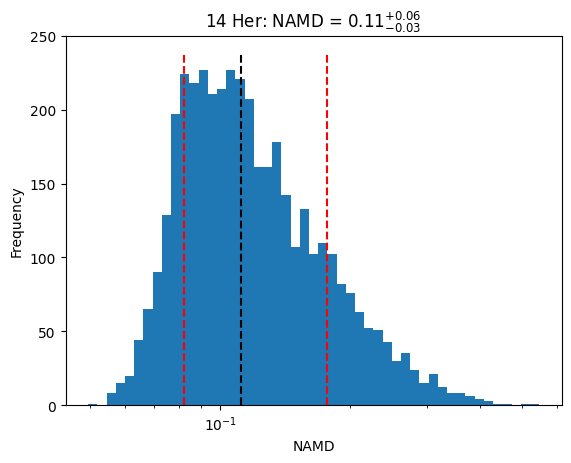

{'q16': 0.08215581947192044,
 'q50': 0.11180422488043931,
 'q84': 0.17652158997486092,
 'N': 2}

In [ ]:
userid = "14 Her"
Npt = 10000

compute_namd(userid, df_clean, Npt)

In [ ]:
results = {}
nsy = len(df_clean.hostname.unique())
q50 = np.zeros(nsy)
multiplicity = np.zeros(nsy)

for k, name in enumerate(df_clean.hostname.unique()):
    results[name] = compute_namd(name, df_clean, Npt=int(1e5), do_plot=False)
    q50[k] = results[name]["q50"]
    multiplicity[k] = results[name]["N"]
    # if multiplicity[k] == 5:
    #     print(name, results[name])

q50nan_index = np.isnan(q50)
multiplicity = multiplicity[~q50nan_index]
q50 = q50[~q50nan_index]

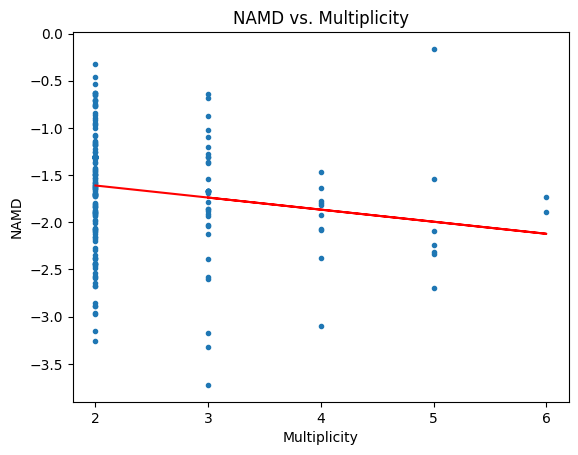

Slope: -0.13, Intercept: -1.35


In [ ]:
plt.figure()
plt.plot(multiplicity, np.log10(q50), '.')
coeffs = np.polyfit(multiplicity, np.log10(q50), 1)
plt.plot(multiplicity, np.polyval(coeffs, multiplicity), 'r')
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.title("NAMD vs. Multiplicity")
plt.xticks(range(2, 7))
plt.show()

print(f"Slope: {coeffs[0]:.2f}, Intercept: {coeffs[1]:.2f}")